# Анализ данных о продажах компьютерных игр

In [1]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats as st
from scipy.stats import binom, norm
from math import factorial, sqrt

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 10)

## Резюме исследования

**Заголовок:** Исследование продаж компьютерных игр на различных игровых платформах за период 1980 - 2016 гг.

**Описание проекта:** Игровая индустрия является одной из наиболее динамично развивающихся сфер современной экономики. По данным отраслевых аналитиков, глобальный рынок видеоигр демонстрирует стабильный рост, превышающий темпы развития многих других секторов развлечений.

Данные о продажах являются критически важным ресурсом для всех участников рынка:
* Разработчики получают инсайты для создания успешных проектов
* Издатели оптимизируют маркетинговые стратегии
* Ритейлеры улучшают ассортиментную политику
* Инвесторы принимают обоснованные решения

**Цель исследования:** Выявить закономерности и факторы, определяющие успешность (прибыльность) игры на рынке. Определить жизненный цикл игровых платформ, а также дать рекомедацию о потенциально популярной платформе для планирования рекламных кампаний.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ продаж в разрезе платформ и жанров, формирование портрета пользователя по регионам продаж, анализ влияния факторов на успешность игр
* Тестирование гипотез

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Описание данных

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Данные за 2016 год могут быть неполными.**

## Шаг 1. Анализ общей информации по датасету

### Вывод первых строк. Изучение общей информации

In [2]:
# Подгружаем датасет
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv', sep=',')

# Выведем на экран первые строки датасета
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Ознакомимся с данными
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Промежуточные выводы

* Объема датасета 16_715 строк
* В столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating` присутствуют пропущенные значения
* Тип данных в столбцах `Year_of_Release` (должен быть datetime), `User_Score` (должен быть float) некорректный
* Наименования столбцов прописаны некорректно, необходимо привести к типу snake_case

## Шаг 2. Предобработка данных

### Замена наименований столбцов

In [4]:
# Приводим наименования столбцов типу snake_case
games.columns = games.columns.str.lower()

# Проверим вносимые изменения
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование типов данных

#### Столбец `year_of_release`

In [5]:
# Приводим тип данных к datetime
games['year_of_release'] = games['year_of_release'].astype('Int64')

# Для преобразования типа данных заполнили пропущенные значениями нулями
#games['year_of_release'] = games['year_of_release'].dt.year

# Смотрим на результат
games['year_of_release'].sort_values().unique()

<IntegerArray>
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, <NA>]
Length: 38, dtype: Int64

In [6]:
# Смотрим на результат
games['year_of_release'].dtype

Int64Dtype()

#### Столбец `user_score`

In [7]:
# Смотрим на значения в столбце user_score
games['user_score'].value_counts()

,count
user_score,
tbd,2424
7.8,324
8,290
8.2,282
8.3,254
...,...
1.3,2
1,2
0.9,2


In [8]:
# Посмотрим на распределение значений TBD по платформам
games.query('user_score == "tbd"')['platform'].value_counts()

,count
platform,
DS,756
Wii,440
GBA,262
PS2,240
XB,150
PSP,123
GC,103
PS3,87
X360,84


В столбце `user_score` имеется 2424 значений **tbd**, что расшифровывается как **To Be Determined** - что можно перевести как **ожидает оценки**.

Можем предположить, что это игры, по которым не подтянулись оценки пользователей (может быть, ошибка при выгрузке базы данных), т.к. год издания этих игр варьируется (есть, например, игры за 2003 и 2011 гг.).

Заполним эти значения на Nan, чтобы привести тип данных к формату `float`.

In [9]:
# Приводим тип данных к float
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

# Смотрим на результат
games['user_score'].dtype

dtype('float64')

### Анализ и заполнение пропущенных значений

In [10]:
# Посмотрим на количество пропущенных значений по столбцам
games.isna().sum()

,0
name,2
platform,0
year_of_release,269
genre,2
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0
critic_score,8578
user_score,9125


In [11]:
# Посмотрим на долю пропущенных значений по столбцам
round(games.isna().mean()*100,1)

,0
name,0.0
platform,0.0
year_of_release,1.6
genre,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0
other_sales,0.0
critic_score,51.3
user_score,54.6


In [12]:
# Удалим пропущенные значения в столбце year_of_release, т.к. их доля менее 5% объема датасета
games.dropna(subset=['year_of_release', 'name'], inplace=True)

# Cмотрим на результат
games.isna().sum()

,0
name,0
platform,0
year_of_release,0
genre,0
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0
critic_score,8461
user_score,8981


In [13]:
# Заполним пустые значения в столбце rating на Unknown
games['rating'].fillna('Unknown', inplace=True)

# Посмотрим, у каких стран чаще всего встречается Uknown в рейтинге
region_columns = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for column in region_columns:
    print(f"Сумма продаж c рейтингом Unknown в регионе {column}: {round(games[games['rating'] == 'Unknown'][column].sum(), 1)}")

Сумма продаж c рейтингом Unknown в регионе na_sales: 1225.8
Сумма продаж c рейтингом Unknown в регионе eu_sales: 609.7
Сумма продаж c рейтингом Unknown в регионе jp_sales: 836.7
Сумма продаж c рейтингом Unknown в регионе other_sales: 149.9


/tmp/ipython-input-13-2411074967.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games['rating'].fillna('Unknown', inplace=True)


Пропущенные значения в столбцах `critic_score`, `user_score` невозможно достоверно заполнить. Оставим их без изменения, т.к. они занимают существенную часть датасета.

### Анализ дубликатов

In [14]:
# Посчитаем количество явных дубликатов
games.duplicated().sum()

np.int64(0)

In [15]:
# Посмотрим, есть ли неявные дубликаты
games['platform'].value_counts()

,count
platform,
PS2,2127
DS,2121
PS3,1306
Wii,1286
X360,1232
PSP,1193
PS,1190
PC,957
GBA,811


In [16]:
# Посмотрим, есть ли неявные дубликаты
games['genre'].value_counts()

,count
genre,
Action,3307
Sports,2306
Misc,1721
Role-Playing,1481
Shooter,1296
Adventure,1293
Racing,1226
Platform,878
Simulation,857


In [17]:
# Создаем временный датафрейм
temp_df = games[games[['name', 'platform','year_of_release']].duplicated(keep=False)]

# Выводим результат
temp_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [18]:
# Создаем агрегированный DataFrame
agg_df = temp_df.groupby(['name', 'platform','year_of_release']).agg({

    # Продажи просуммируем, по всем остальным столбцам оставим первое вхождение

    'genre': 'first',

    'na_sales':'sum',
    'eu_sales':'sum',
    'jp_sales':'sum',
    'other_sales':'sum',

    'critic_score': 'first',
    'user_score': 'first',
    'rating': 'first',
}).reset_index()

# Выводим на экран
agg_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


In [19]:
# Объединяем 2 датафрейма
games = pd.concat([games, agg_df], ignore_index=True)

# Проверяем дубликаты повторно
games[games[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
600,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
15969,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E
16444,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


In [20]:
# Удаляем дубликаты, сохраняя последнюю агрегированную строку
games.drop_duplicates(subset=['name', 'platform','year_of_release'], keep='last', inplace=True)

# Проверяем дубликаты повторно
games[games[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


### Добавление столбца с суммарными продажами по регионам

In [21]:
# Добавляем столбец с суммарными продажами
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

# Смотрим на результат
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38


### Промежуточные выводы

* Приведен в соответствие тип данных для столбцов
    * `year_of_release` -> int
    * `user_score` -> float


* Пропущенные значения в столбцах `critic_score`, `user_score`, `rating` невозможно достоверно заполнить. Поэтому, чтобы избежать искажений при анализе игр на основе этих столбцов, оставим пропущенные значения без изменений. Скорее всего это случайно пропущенные значения (ошибки при выгрузке данных). Кроме того, мы не знаем правил, по которым эта база заполнялась. Возможно, не было строгих правил по заполнению столбцов, кроме продаж по регионам, они заполнены без пропусков.


* Создан новый столбец `total_sales` с подсчетом суммарных продаж по каждой игре.


* В датасете обработаны неявные дубликаты, явные - не обнаружены.

## Шаг 3. Исследовательский анализ данных

### Анализ суммарных продаж

#### Анализ суммарных продаж за все периоды

In [22]:
# Группируем данные
games_sales_per_year = games.groupby('year_of_release')['total_sales'].sum().reset_index()

# Выводим результат
games_sales_per_year

,year_of_release,total_sales
0,1980,11.38
1,1981,35.68
2,1982,28.88
3,1983,16.80
4,1984,50.35
5,1985,53.95
6,1986,37.08
7,1987,21.70
8,1988,47.21
9,1989,73.45


In [23]:
# Проверяем суммарные продажи исходного датасета
print('Суммарные продажи игр исходного датасета', games['total_sales'].sum())

# Проверяем суммарные продажи сгруппированного датасета
print('Суммарные продажи игр сгруппированного по годам датасета', games_sales_per_year['total_sales'].sum())

# Отклонение
print('Отклонение', games['total_sales'].sum() - games_sales_per_year['total_sales'].sum())

# Считаем суммарные продажи по строкам с незаполненным годом релиза
print('Суммарные продажи по строкам с незаполненным годом релиза', games.loc[games['year_of_release'].isna()]['total_sales'].sum())

Суммарные продажи игр исходного датасета 8814.369999999999
Суммарные продажи игр сгруппированного по годам датасета 8814.37
Отклонение -1.8189894035458565e-12
Суммарные продажи по строкам с незаполненным годом релиза 0.0


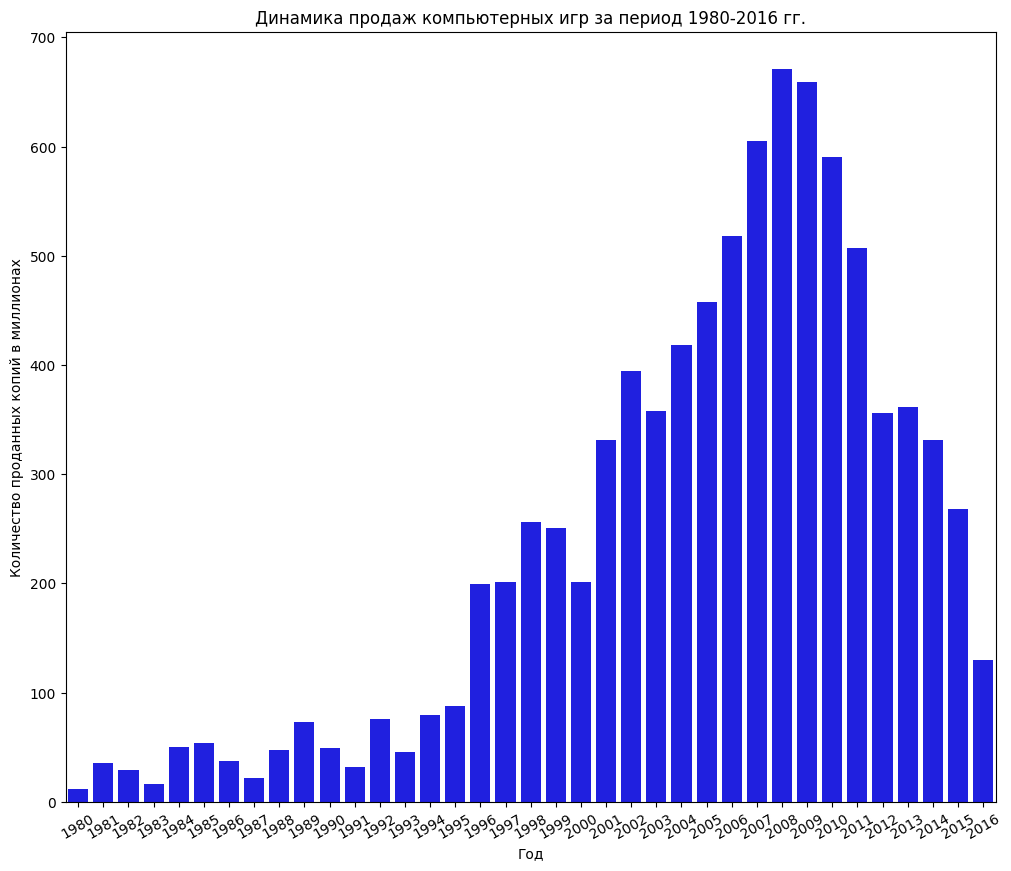

In [24]:
# Создание гистограммы
sns.barplot(data=games_sales_per_year, x='year_of_release', y='total_sales', color='blue')

# Заголовок и подписи осей
plt.title('Динамика продаж компьютерных игр за период 1980-2016 гг.')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий в миллионах')

# Добавим наклон для подписей оси X:
plt.xticks(rotation=30)

plt.show()

По графику виден рост суммарных продаж вплоть до 2008 года, после чего наблюдается снижение показателя до 2015 года (с учетом того, что данные за 2016 год могут быть неполными).

In [25]:
# Смотрим на распределение количества игр по годам
games['year_of_release'].value_counts().sort_index()

,count
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


В 1996 году наблюдается двухратный рост относительно 1995 года. Скорее всего это связано с релизом новой игры. Проверим это предположение.

In [26]:
games_1995_1996 = games.query('year_of_release == 1995 or year_of_release == 1996').groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

games_1995_1996

/tmp/ipython-input-26-1819387444.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  games_1995_1996 = games.query('year_of_release == 1995 or year_of_release == 1996').groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()


,platform,year_of_release,total_sales
0,3DO,1995,0.08
1,GB,1995,3.60
2,GB,1996,36.03
3,N64,1996,34.10
4,NG,1995,0.33
5,NG,1996,0.10
6,PC,1995,4.22
7,PC,1996,10.58
8,PCFX,1996,0.03
9,PS,1995,35.96


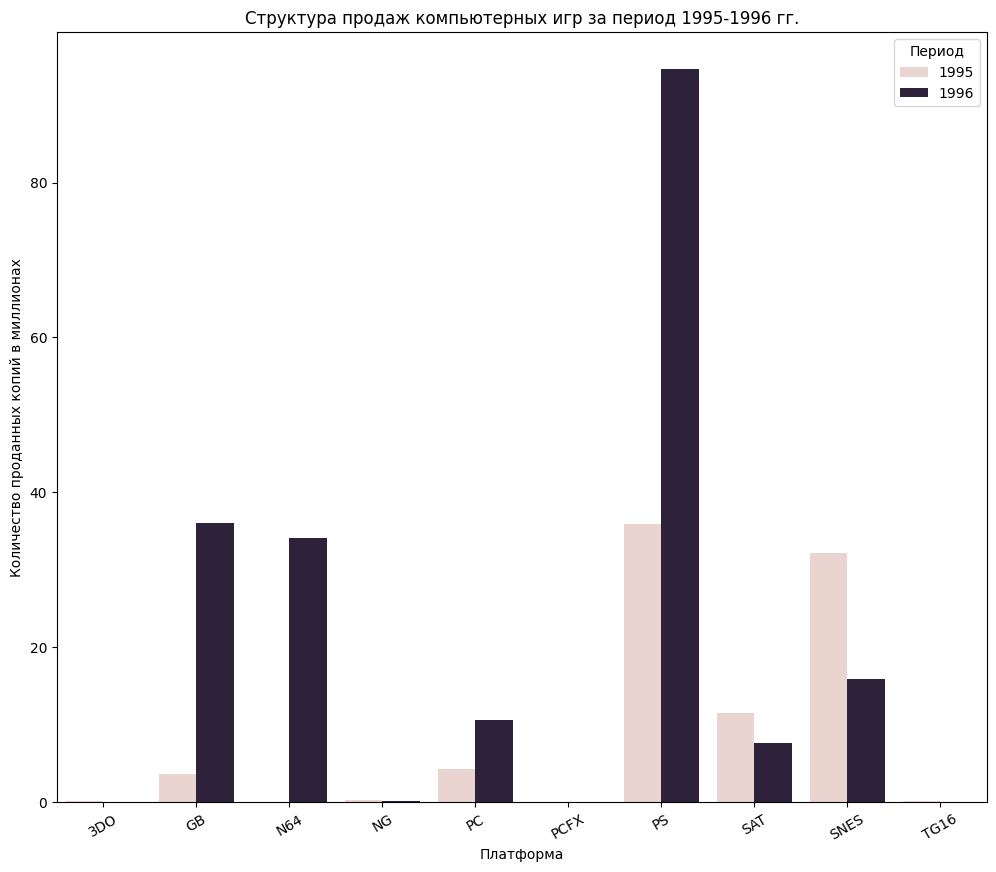

In [27]:
# Создание гистограммы
sns.barplot(data=games_1995_1996, x='platform', y='total_sales', hue='year_of_release')

# Заголовок и подписи осей
plt.title('Структура продаж компьютерных игр за период 1995-1996 гг.')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий в миллионах')

# Добавим наклон для подписей оси X:
plt.xticks(rotation=30)
plt.legend(title='Период')

plt.show()

Мы видим значительный рост по платформам Gameboy, Nintendo и Playstation. Посмотрим, какие игры были в топ-продажах на этих платформах в 1996 году.

In [28]:
# Выведем 5 самых продаваемых игр на платформе Gameboy
top_games_GB_96 = (
    games
    .query('year_of_release == 1996 and platform == "GB"')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .head()
)

# Смотрим на результат
top_games_GB_96

/tmp/ipython-input-28-437903233.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('year_of_release == 1996 and platform == "GB"')


,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38
1,665,Donkey Kong Land II,GB,1996,Platform,1.39,0.48,0.40,0.08,NaN,NaN,Unknown,2.35
2,1303,Tamagotchi,GB,1996,Simulation,0.00,0.00,1.44,0.01,NaN,NaN,Unknown,1.45
3,5185,Picross 2,GB,1996,Puzzle,0.00,0.00,0.35,0.00,NaN,NaN,Unknown,0.35
4,6207,Fushigi no Dungeon: Fuurai no Shiren GB: Tsuki...,GB,1996,Role-Playing,0.00,0.00,0.27,0.00,NaN,NaN,Unknown,0.27


In [29]:
# Выведем 5 самых продаваемых игр на платформе Nintendo64
top_games_N64_96 = (
    games
    .query('year_of_release == 1996 and platform == "N64"')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .head()
)

# Смотрим на результат
top_games_N64_96

/tmp/ipython-input-29-1235465232.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('year_of_release == 1996 and platform == "N64"')


,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,45,Super Mario 64,N64,1996,Platform,6.91,2.85,1.91,0.23,NaN,NaN,Unknown,11.90
1,63,Mario Kart 64,N64,1996,Racing,5.55,1.94,2.23,0.15,NaN,NaN,Unknown,9.87
2,482,Wave Race 64,N64,1996,Racing,1.98,0.58,0.34,0.04,NaN,NaN,Unknown,2.94
3,572,Star Wars: Shadows of the Empire,N64,1996,Action,2.00,0.50,0.12,0.03,NaN,NaN,Unknown,2.65
4,1013,Cruis'n USA,N64,1996,Racing,1.69,0.04,0.00,0.01,NaN,NaN,Unknown,1.74


In [30]:
# Выведем 5 самых продаваемых игр на платформе Playstation
top_games_PS_96 = (
    games
    .query('year_of_release == 1996 and platform == "PS"')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .head()
)

# Смотрим на результат
top_games_PS_96

/tmp/ipython-input-30-2431030509.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('year_of_release == 1996 and platform == "PS"')


,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,115,Crash Bandicoot,PS,1996,Platform,3.23,2.35,0.94,0.30,NaN,NaN,Unknown,6.82
1,153,Tekken 2,PS,1996,Fighting,2.26,1.89,1.36,0.23,89.0,8.9,T,5.74
2,202,Resident Evil,PS,1996,Action,2.05,1.16,1.11,0.73,91.0,9.0,M,5.05
3,228,Tomb Raider,PS,1996,Action,2.29,1.97,0.13,0.24,91.0,8.6,T,4.63
4,295,Namco Museum Vol.3,PS,1996,Misc,2.28,1.55,0.16,0.06,NaN,NaN,Unknown,4.05


#### Анализ суммарных продаж по платформам

In [31]:
# Посмотрим на платформы с топовыми суммарными продажами
games_sales_by_platform = (games.groupby('platform')['total_sales'].sum().reset_index()
                           .sort_values(by='total_sales', ascending=False))

# Выводим результат
games_sales_by_platform.head()

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78


In [32]:
# Посмотрим на распределение
games_sales_by_platform.describe()

,total_sales
count,31.000000
mean,284.334516
std,343.954144
min,0.030000
25%,22.150000
50%,200.040000
75%,301.205000
max,1233.560000


In [33]:
# Проанализируем платформы с суммарными продажами больше 304 (третий квартиль)
games_sales_by_platform_top = games_sales_by_platform.query('total_sales > 304')

In [34]:
# Объединим перечень топ-платформ в список
top_platforms = games_sales_by_platform_top['platform'].tolist()

# Выведем результат на экран
top_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA']

In [35]:
# Отфильтруем датасет - оставим только топ-платформы
games_top_platforms = games.query('platform in @top_platforms')

# Выведем результат на экран
games_top_platforms

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16438,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,Unknown,0.00
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16440,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,Unknown,0.01
16442,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,Unknown,0.01


In [36]:
# Группируем данные для построения графика
games_top_platforms_grouped = (games_top_platforms
                               .query('year_of_release > 1985')
                               .groupby(['platform', 'year_of_release'])['total_sales'].sum()
                               .reset_index()
                              )

# Смотрим результат
games_top_platforms_grouped

/tmp/ipython-input-36-869480784.py:3: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('year_of_release > 1985')


,platform,year_of_release,total_sales
0,DS,2004,17.27
1,DS,2005,130.14
2,DS,2006,119.81
3,DS,2007,146.94
4,DS,2008,145.31
...,...,...,...
73,X360,2012,99.74
74,X360,2013,88.58
75,X360,2014,34.74
76,X360,2015,11.96


In [37]:
# Создаем интерактивный график
fig = px.line(
    data_frame=games_top_platforms_grouped,
    x='year_of_release',
    y='total_sales',
    color='platform',
    title='Динамика продаж компьютерных игр в разрезе топовых платформ',
    labels={
        'year_of_release': 'Год',
        'total_sales': 'Количество проданных копий в миллионах',
        'platform': 'Платформа'
    }
)

# Настраиваем макет графика
fig.update_layout(
    xaxis={
        'tickmode': 'linear',  # Линейный режим тиков
        'tick0': games_top_platforms_grouped['year_of_release'].min(),  # Начало
        'dtick': 1  # Шаг в 1 год
    },
    legend=dict(
        title='Платформы',
        x=0,
        y=1
    )
)

# Показываем график
fig.show()

На графике видно жизненный цикл топ-платформ, а именно:
* Wii - с 2006 (10 лет на дату выгрузки данных)
* DS (Nintendo) - с 1985 по 2013 (28 лет, аномалия)
* X360 - с 2005 (11 лет на дату выгрузки данных)
* PS3 - с 2006 (на дату выгрузки данных)
* PS2 - с 2000 по 2011 (11 лет)
* GBA - с 2000 по 2007 (7 лет)
* PS4 - с 2013 (3 года на дату выгрузки данных)
* PS - с 1994 по 2003 (10 лет)

Характерный срок, за который исчезают старые платформы, и появляются новые - 10 лет.

#### Выбор актуального периода для анализа

In [38]:
# Сформируем обновленный список топ-платформ по суммарным продажам
games_filtered = games.groupby('platform').agg({'total_sales':'sum', 'year_of_release':'min'}).reset_index().sort_values(by='total_sales', ascending=False)

# Смотрим на результат
games_filtered.head(10)

,platform,total_sales,year_of_release
16,PS2,1233.56,2000
28,X360,961.24,2005
17,PS3,931.34,2006
26,Wii,891.18,2006
4,DS,802.78,1985
15,PS,727.58,1994
18,PS4,314.14,2013
6,GBA,312.88,2000
19,PSP,289.53,2004
2,3DS,257.81,2011


In [39]:
# Выбираем относительно молодые платформы не старше 5 лет
chosen_platform = games_filtered.query('year_of_release > 2011')

# Смотрим на результат
chosen_platform

/tmp/ipython-input-39-3339931558.py:2: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



,platform,total_sales,year_of_release
18,PS4,314.14,2013
30,XOne,159.32,2013
27,WiiU,82.19,2012


In [40]:
chosen_platform_list = chosen_platform['platform'].tolist()

chosen_platform_list

['PS4', 'XOne', 'WiiU']

#### Выбор потенциально прибыльных платформ

In [41]:
# Группируем данные для построения графика
games_chosen_platform = (games.query('platform in @chosen_platform_list')
                         .dropna(subset=['year_of_release'])
                         .groupby(['platform', 'year_of_release'])['total_sales'].sum()
                         .reset_index()
                        )

# Смотрим на результат
games_chosen_platform

,platform,year_of_release,total_sales
0,PS4,2013,25.99
1,PS4,2014,100.00
2,PS4,2015,118.90
3,PS4,2016,69.25
4,WiiU,2012,17.56
5,WiiU,2013,21.65
6,WiiU,2014,22.03
7,WiiU,2015,16.35
8,WiiU,2016,4.60
9,XOne,2013,18.96


In [42]:
# Создаем интерактивный график
fig = px.line(
    data_frame=games_chosen_platform,
    x='year_of_release',
    y='total_sales',
    color='platform',
    title='Динамика продаж компьютерных игр в разрезе топовых платформ',
    labels={
        'year_of_release': 'Год',
        'total_sales': 'Количество проданных копий в миллионах',
        'platform': 'Платформа'
    }
)

# Настраиваем макет графика
fig.update_layout(
    xaxis={
        'tickmode': 'linear',  # Линейный режим тиков
        'tick0': games_top_platforms_grouped['year_of_release'].min(),  # Начало
        'dtick': 1  # Шаг в 1 год
    },
    legend=dict(
        title='Платформы',
        x=0,
        y=1
    )
)

# Показываем график
fig.show()

По графику видно, что по всем платформам наметился спад продаж. Учитывая то, что PS4 и XboxOne вышли только в 2013 году и у них самый высокий наблюдаемый пик продаж, можно рассчитывать на потенциал роста в будущем.

#### Анализ глобальных продаж в разбивке по платформам

In [43]:
# Создаем интерактивный график
fig = px.box(
    data_frame=games.query('year_of_release > 2011'),
    x='platform',
    y='total_sales',
    title='Распределение глобальных продаж компьютерных игр в разрезе топ-платформ',
    labels={'platform': 'Платформа', 'total_sales': 'Количество проданных копий в миллионах'},
    color='platform',  # Добавляем цветовую дифференциацию
)

# Настраиваем диапазон оси Y
fig.update_yaxes(range=[0, 5])

# Добавляем дополнительные настройки визуализации
fig.update_layout(
    xaxis_title='Платформа',
    yaxis_title='Количество проданных копий в миллионах',
    boxmode='group',  # Группируем ящики
    hovermode='closest',  # Настройка всплывающих подсказок
    legend_title='Платформа'
)

# Показываем график
fig.show()

/tmp/ipython-input-43-4251885132.py:3: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



* По графику видно, что самые высокие продажи в абсолютном выражении из актуальных платформ - у Playstation4.
* Примечательно, что самые высокие медианы продаж в районе 0.2-0.3 млн. копий.
* Однако, максимальный уровень продаж среди всех платформ у Playstation3. Далее идут Xbox360 и Nintendo 3DS.

#### Промежуточные выводы

* Анализ суммарных продаж по всем платформам показал рост вплоть до 2008 года, после чего наблюдается снижение показателя.
* Платформы с наибольшими суммарными продажами за период с 1980 по 2016 гг. это PlayStation (1-4 поколения), Xbox360, Nintendo ('Wii', 'DS', 'GBA').
* Платформы сохраняют актуальность в течение 10 лет, после чего снимаются с производства. Учитывая это, актуальным периодом для исследовательского анализа выбран промежуток 5 лет с 2012 по 2016 гг.
* Самыми прибыльными за актуальный период оказались платформы PlayStation 4, XboxOne и Nintendo 'WiiU'.
* В качестве потенциально прибыльных можно рассмотреть платформы PS4 и XboxOne как наиболее актуальные (запущены в 2013 году) и прибыльные за выбранный период.
* Анализ распределения глобальных продаж в разрезе:
    * топ-платформ показал первенство Playstation4 (примечательно, что эта платформа также оказалась наиболее быстрорастущей, по уровню продаж с 2013 по 2015 гг. рост более чем в 5 раз). Далее идут XboxOne и Nintendo 'WiiU'.
    * всех платформ показал первенство Playstation3, далее идут Xbox360 и Nintendo 3DS.

### Анализ глобальных продаж Playstation4 в разрезе жанров

In [44]:
# Группируем данные для построения графика
games_chosen_platform_ps4 = (games.query('platform == "PS4"')
                         .dropna(subset=['year_of_release'])
                         .groupby(['year_of_release', 'genre'])['total_sales'].sum()
                         .reset_index()
                        )

# Смотрим на результат
games_chosen_platform_ps4

,year_of_release,genre,total_sales
0,2013,Action,4.48
1,2013,Fighting,0.92
2,2013,Misc,0.42
3,2013,Platform,2.27
4,2013,Racing,1.98
5,2013,Shooter,10.10
6,2013,Sports,5.60
7,2013,Strategy,0.22
8,2014,Action,43.57
9,2014,Adventure,1.18


In [45]:
# Создаем интерактивную гистограмму
fig = px.bar(
    data_frame=games_chosen_platform_ps4,
    x='year_of_release',
    y='total_sales',
    color='genre',
    title='Структура продаж компьютерных игр Playstation 4 в разрезе жанров',
    labels={
        'year_of_release': 'Год релиза игры',
        'total_sales': 'Количество проданных копий в миллионах',
        'genre': 'Жанр'
    }
)

# Настраиваем макет графика
fig.update_layout(
    xaxis={
        'title': 'Год релиза игры',
        'tickangle': 30, # Наклон подписей оси X
        'dtick': 1  # Шаг в 1 год
    },
    yaxis={
        'title': 'Количество проданных копий в миллионах'
    },
    legend=dict(
        title='Жанр',
        x=0,
        y=1
    )
)

# Добавляем всплывающие подсказки
fig.update_traces(
    hovertemplate=
    '<b>Год</b>: %{x}<br>' +
    '<b>Продажи</b>: %{y:.2f} млн<br>'
)

# Показываем график
fig.show()

Мы видим, что пик продаж приходится на 2014-2015 гг.:

* в 2014 году самые популярные жанры это:
    * `action` (43.57 млн. копий)
    * `shooter` (21.3 млн. копий)
    * `sports` (15.34 млн. копий)


* в 2015 году:
    * `action` (33.2 млн. копий)
    * `shooter` (32.97 млн. копий)
    * `sports` (20.09 млн. копий)
    * `role-playing` (17.53 млн. копий)
    
В 2016 году отметим падение продаж по жанрам `action` и `role-playing` более, чем в 2 раза (но данные могут быть неполные).

#### Влияние отзывов пользователей на глобальные продажи игр Playstation4

In [46]:
# Группируем данные для построения графика
ps4_user_score_impact = games.query('platform == "PS4" and user_score.notna()')

# Смотрим на распределение оценок
ps4_user_score_impact['user_score'].describe()

,user_score
count,257.000000
mean,6.748249
std,1.459481
min,1.500000
25%,6.100000
50%,7.000000
75%,7.800000
max,9.200000


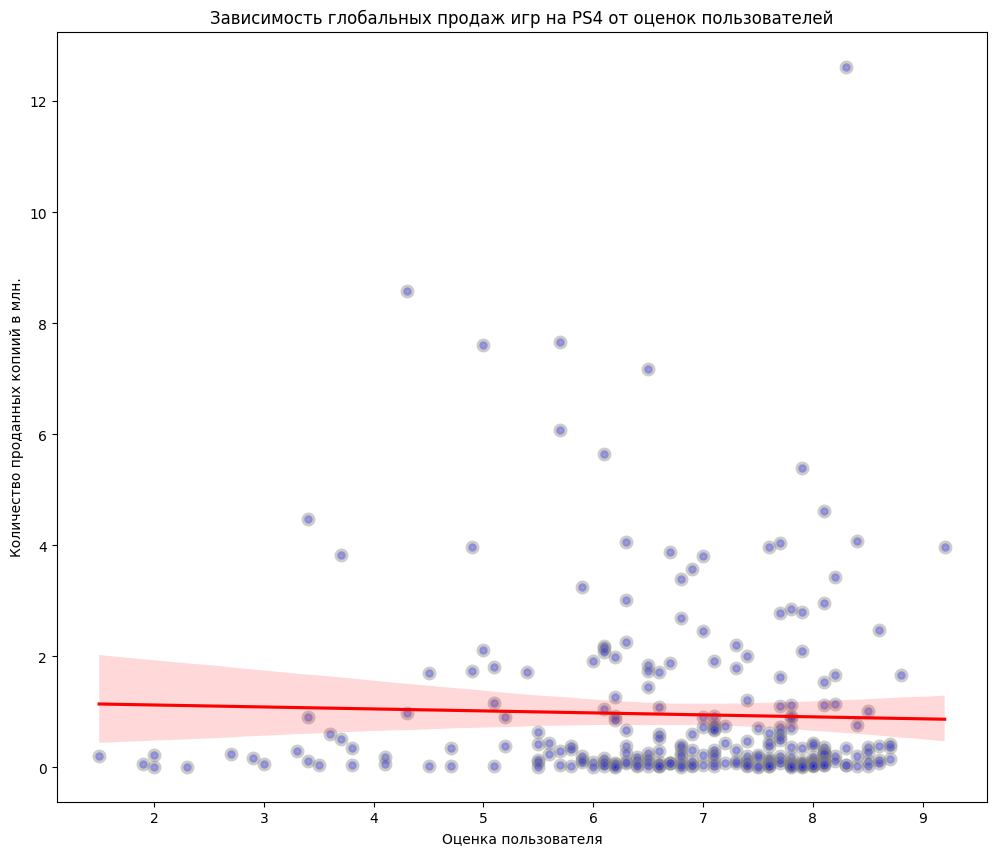

In [47]:
# Строим точечную диаграмму
plt.scatter(x=ps4_user_score_impact['user_score'],
            y=ps4_user_score_impact['total_sales'],
            c="blue",  # цвет точек
            linewidths = 4, # ширина границы точки (4)
            edgecolors = 'gray', # цвет границы точки
            alpha = 0.4) # уровень прозрачности

# Добавляем линию тренда
sns.regplot(
    x=ps4_user_score_impact['user_score'],
    y=ps4_user_score_impact['total_sales'],
    data=ps4_user_score_impact,
    scatter=False,
    color='red'
)

plt.title('Зависимость глобальных продаж игр на PS4 от оценок пользователей')
plt.xlabel('Оценка пользователя')
plt.ylabel('Количество проданных копиий в млн.')
plt.show()

БОльшая часть игр, которые продаются тиражом более 2 млн. копий сосредоточена в правой части графика, где оценки пользователей больше 6.

Но линия тренда имеет практически прямой наклон - это значит, что оценки пользователей практически не влияют на продажи.

#### Влияние отзывов критиков на глобальные продажи игр Playstation4

In [48]:
# Группируем данные для построения графика
ps4_critic_score_impact = games.query('platform == "PS4" and critic_score.notna()')

# Смотрим на распределение оценок
ps4_critic_score_impact['critic_score'].describe()

,critic_score
count,252.000000
mean,72.091270
std,12.485992
min,19.000000
25%,66.000000
50%,73.000000
75%,80.000000
max,97.000000


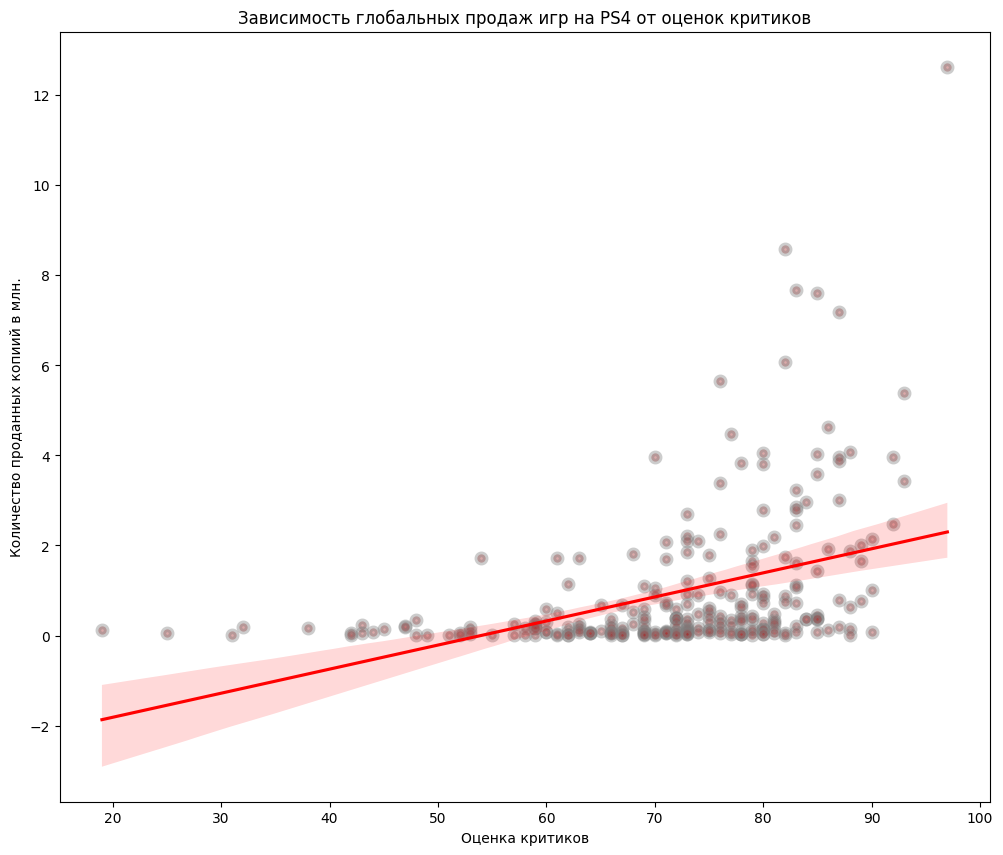

In [49]:
# Строим точечную диаграмму
plt.scatter(x=ps4_critic_score_impact['critic_score'],
            y=ps4_critic_score_impact['total_sales'],
            c="brown",  # цвет точек
            linewidths = 4, # ширина границы точки (4)
            edgecolors = 'gray', # цвет границы точки
            alpha = 0.4) # уровень прозрачности

# Добавляем линию тренда
sns.regplot(
    x=ps4_critic_score_impact['critic_score'],
    y=ps4_critic_score_impact['total_sales'],
    data=ps4_critic_score_impact,
    scatter=False,
    color='red'
)

plt.title('Зависимость глобальных продаж игр на PS4 от оценок критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Количество проданных копиий в млн.')
plt.show()

БОльшая часть игр, которые продаются тиражом более 2 млн. копий сосредоточена в правой части графика, где оценки критиков больше 55.

Линия тренда восходящая - это значит, что оценки критиков влияют на продажи игр PS4. Это подтверждается тем, что тираж в районе 2 млн. копий и выше только у игр с рейтингом от 55 и выше.

#### Матрица корреляции глобальных продаж игр на PS4 и оценок пользователей и критиков

In [50]:
# Отфильтруем необходимые значения
ps4_corr = games.query('platform == "PS4" and critic_score.notna() and user_score.notna()')

# Выделим необходимые столбцы
columns_matrix = ['total_sales', 'user_score', 'critic_score']

# Построим матрицу корреляции
round(ps4_corr[columns_matrix].corr(), 2)

,total_sales,user_score,critic_score
total_sales,1.00,-0.03,0.41
user_score,-0.03,1.00,0.56
critic_score,0.41,0.56,1.00


#### Промежуточные выводы

Таким образом, предположение о том, что оценки критиков влияют на глобальные продажи игр на PS4 подтвердились. Следует отметить, что коррялция выражена средне.
Оценки пользователей, как видно, практически не влияют на продажи.

### Матрица корреляции глобальных продаж игр на других платформах и оценок пользователей и критиков

#### XOne

In [51]:
# Отфильтруем необходимые значения
xone_corr = games.query('platform == "XOne" and critic_score.notna() and user_score.notna()')

# Выделим необходимые столбцы
columns_matrix = ['total_sales', 'user_score', 'critic_score']

# Построим матрицу корреляции
round(xone_corr[columns_matrix].corr(), 2)

,total_sales,user_score,critic_score
total_sales,1.00,-0.09,0.41
user_score,-0.09,1.00,0.47
critic_score,0.41,0.47,1.00


#### WiiU

In [52]:
# Отфильтруем необходимые значения
wiiu_corr = games.query('platform == "WiiU" and critic_score.notna() and user_score.notna()')

# Выделим необходимые столбцы
columns_matrix = ['total_sales', 'user_score', 'critic_score']

# Построим матрицу корреляции
round(wiiu_corr[columns_matrix].corr(), 2)

,total_sales,user_score,critic_score
total_sales,1.00,0.39,0.35
user_score,0.39,1.00,0.77
critic_score,0.35,0.77,1.00


#### PSV

In [53]:
# Отфильтруем необходимые значения
psv_corr = games.query('platform == "PSV" and critic_score.notna() and user_score.notna()')

# Выделим необходимые столбцы
columns_matrix = ['total_sales', 'user_score', 'critic_score']

# Построим матрицу корреляции
round(psv_corr[columns_matrix].corr(), 2)

,total_sales,user_score,critic_score
total_sales,1.00,0.04,0.13
user_score,0.04,1.00,0.73
critic_score,0.13,0.73,1.00


#### Nintendo 3DS

In [54]:
# Отфильтруем необходимые значения
ds3_corr = games.query('platform == "3DS" and critic_score.notna() and user_score.notna()')

# Выделим необходимые столбцы
columns_matrix = ['total_sales', 'user_score', 'critic_score']

# Построим матрицу корреляции
round(ds3_corr[columns_matrix].corr(), 2)

,total_sales,user_score,critic_score
total_sales,1.00,0.23,0.34
user_score,0.23,1.00,0.75
critic_score,0.34,0.75,1.00


#### Влияние оценок пользователей на глобальные продажи игр нескольких платформ

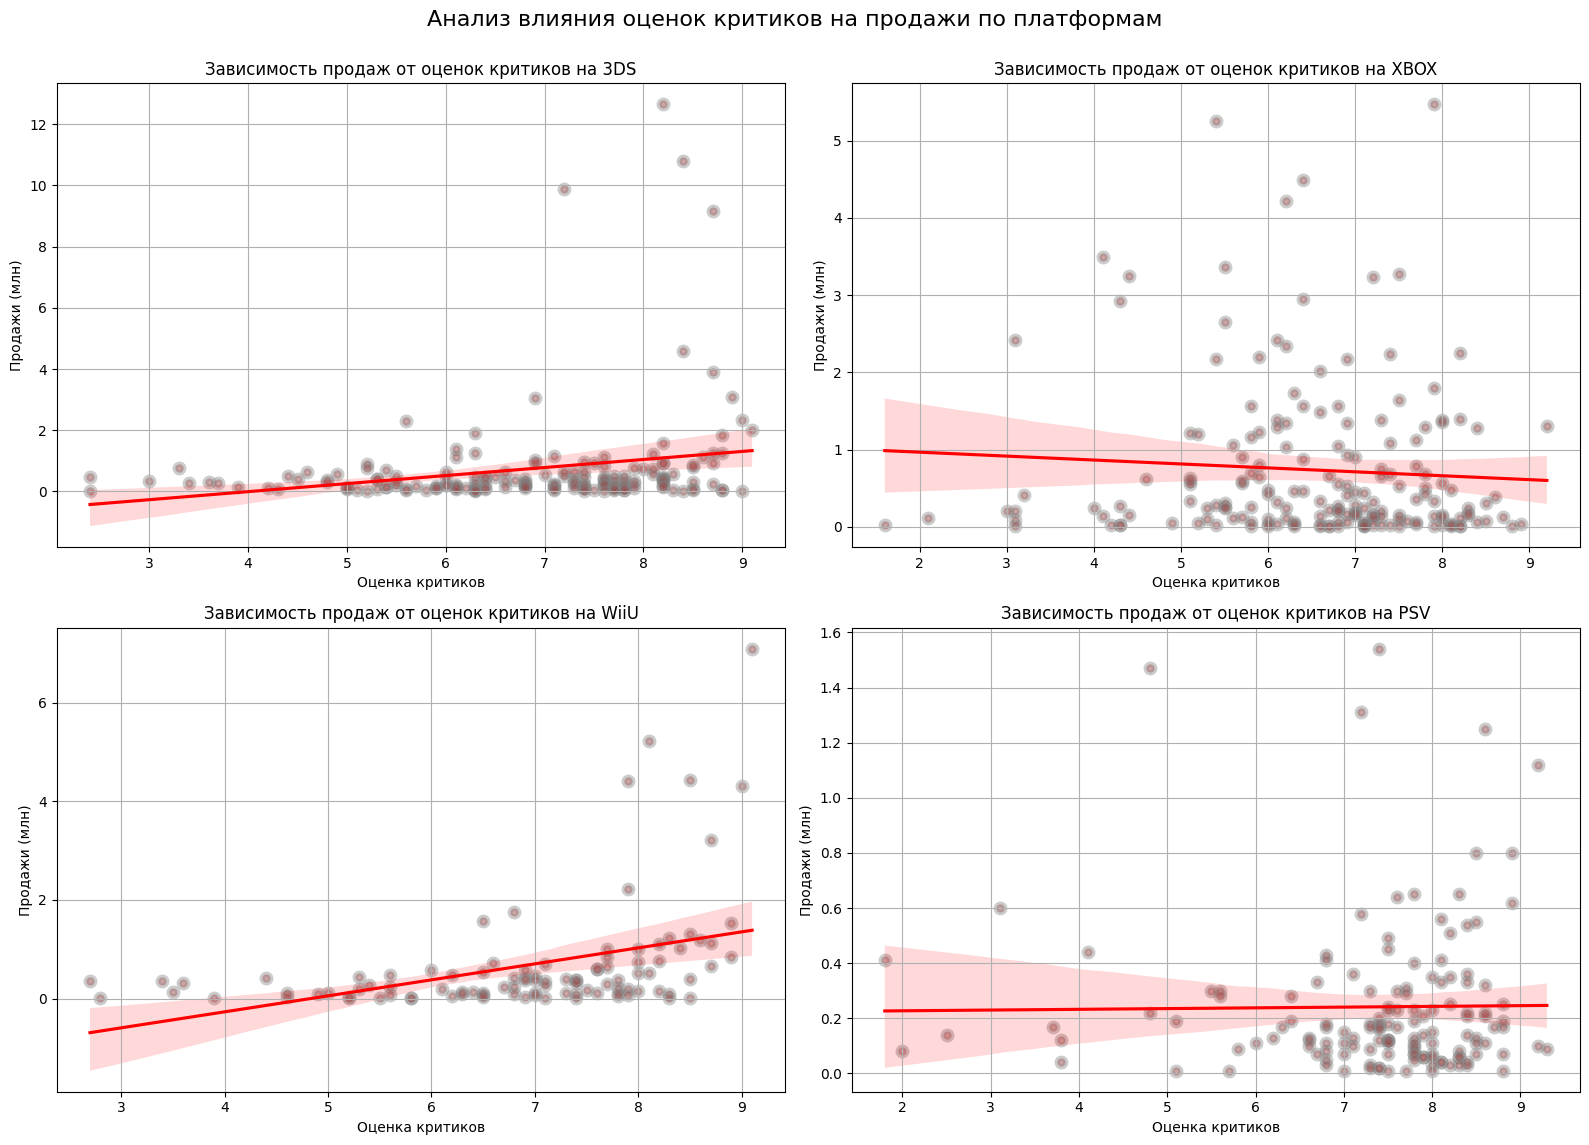

In [55]:
# Предположим, у нас есть словарь с данными по разным платформам
platforms_data = {
    '3DS': games.query('platform == "3DS" and user_score.notna()'),
    'XBOX': games.query('platform == "XOne" and user_score.notna()'),
    'WiiU': games.query('platform == "WiiU" and user_score.notna()'),
    'PSV': games.query('platform == "PSV" and user_score.notna()')
}

# Создаем фигуру с несколькими подграфиками
plt.figure(figsize=(16, 12))

# Перебираем платформы и создаем график для каждой
for i, (platform, data) in enumerate(platforms_data.items(), start=1):
    plt.subplot(2, 2, i)  # Создаем сетку 2x2

    # Точечная диаграмма
    plt.scatter(
        x=data['user_score'],
        y=data['total_sales'],
        c='brown',
        linewidths=4,
        edgecolors='gray',
        alpha=0.4
    )

    # Линия тренда
    sns.regplot(
        x='user_score',
        y='total_sales',
        data=data,
        scatter=False,
        color='red'
    )

    # Настройка заголовка и подписей
    plt.title(f'Зависимость продаж от оценок критиков на {platform}')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи (млн)')
    plt.grid(True)

# Настройка общего отображения
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Добавляем отступ сверху
plt.suptitle('Анализ влияния оценок критиков на продажи по платформам', fontsize=16)
plt.show()

#### Влияние оценок критиков на глобальные продажи игр нескольких платформ

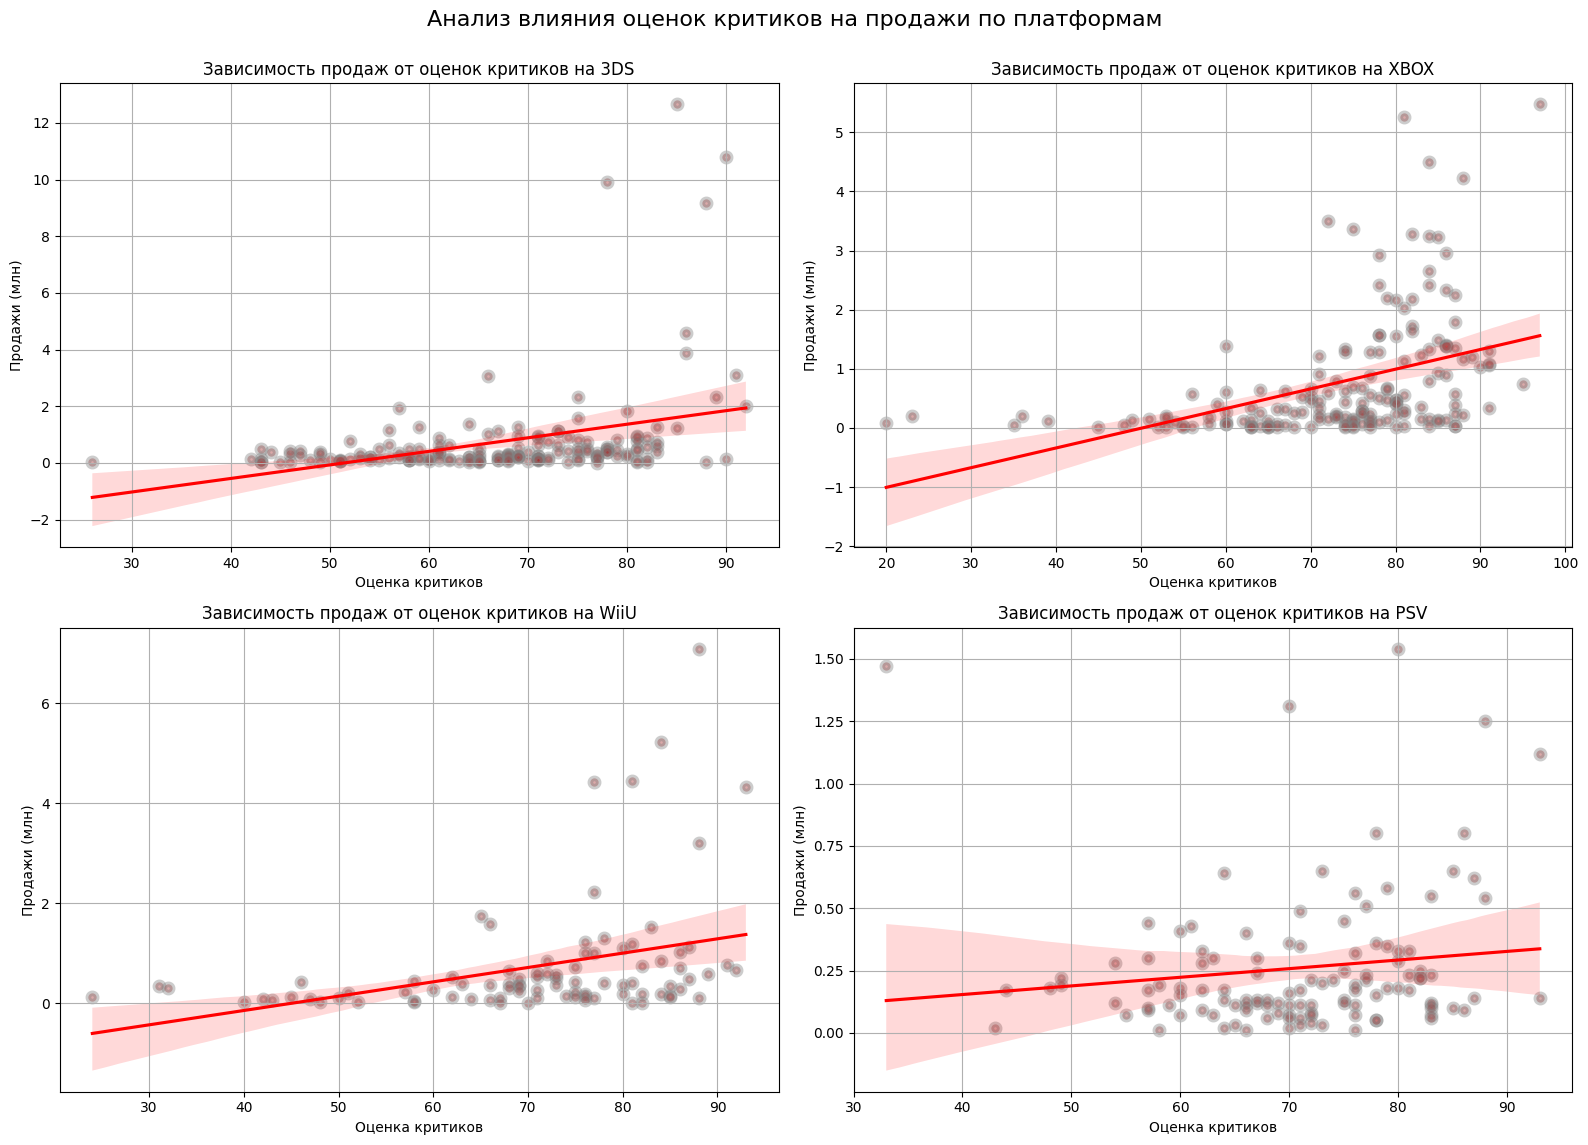

In [56]:
# Предположим, у нас есть словарь с данными по разным платформам
platforms_data = {
    '3DS': games.query('platform == "3DS" and critic_score.notna()'),
    'XBOX': games.query('platform == "XOne" and critic_score.notna()'),
    'WiiU': games.query('platform == "WiiU" and critic_score.notna()'),
    'PSV': games.query('platform == "PSV" and critic_score.notna()')
}

# Создаем фигуру с несколькими подграфиками
plt.figure(figsize=(16, 12))

# Перебираем платформы и создаем график для каждой
for i, (platform, data) in enumerate(platforms_data.items(), start=1):
    plt.subplot(2, 2, i)  # Создаем сетку 2x2

    # Точечная диаграмма
    plt.scatter(
        x=data['critic_score'],
        y=data['total_sales'],
        c='brown',
        linewidths=4,
        edgecolors='gray',
        alpha=0.4
    )

    # Линия тренда
    sns.regplot(
        x='critic_score',
        y='total_sales',
        data=data,
        scatter=False,
        color='red'
    )

    # Настройка заголовка и подписей
    plt.title(f'Зависимость продаж от оценок критиков на {platform}')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи (млн)')
    plt.grid(True)

# Настройка общего отображения
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Добавляем отступ сверху
plt.suptitle('Анализ влияния оценок критиков на продажи по платформам', fontsize=16)
plt.show()

#### Промежуточные выводы

* Влияние оценок пользователей на продажи подтвердилось по следующим платформам (2 из 5 платформ):
    * WiiU 0.39
    * Nintendo 3DS 0.23


* Влияние оценок критиков на продажи подтвердилось по следующим платформам (4 из 5 платформ):
    * PS4 0.41
    * XOne 0.41
    * WiiU 0.35
    * Nintendo 3DS 0.34
    * PSV 0.13 (слабая корреляция)

### Анализ жанров по прибыльности

In [57]:
# Создаем интерактивный график
fig = px.box(
    data_frame=games.query('platform in @chosen_platform_list'),
    x='genre',
    y='total_sales',
    title='Распределение глобальных продаж компьютерных игр в разрезе жанров',
    labels={'platform': 'Платформа', 'total_sales': 'Количество проданных копий в миллионах'},
    category_orders={'genre': (games
     .query('platform in @chosen_platform_list')
     .groupby('genre')['total_sales'].median()
     .sort_values(ascending=False)
     .index)}
)

# Настраиваем диапазон оси Y
fig.update_yaxes(range=[0, 6])

# Добавляем дополнительные настройки визуализации
fig.update_layout(
    xaxis_title='Жанр',
    yaxis_title='Количество проданных копий в миллионах',
    boxmode='group',  # Группируем ящики
    hovermode='closest',  # Настройка всплывающих подсказок
    legend_title='Платформа'
)

# Показываем график
fig.show()

#### Промежуточные выводы

Самые **стабильно прибыльные** (самая высокая медиана продаж) жанры:

   * `shooter`
   * `sports`
   * `platform`
   
    
Самые **низкие продажи** в жанрах:

   * `strategy`
   * `adventure`
   * `puzzle`

### Промежуточные итоги

**Итоги исследовательского анализа данных:**

* Анализ суммарных продаж по всем платформам показал рост вплоть до 2008 года, после чего наблюдается снижение показателя.
* Платформы с наибольшими суммарными продажами за период с 1980 по 2016 гг. это PlayStation (1-4 поколения), Xbox360, Nintendo ('Wii', 'DS', 'GBA').
* Платформы сохраняют актуальность в течение 10 лет, после чего снимаются с производства. Учитывая это, актуальным периодом для исследовательского анализа выбран промежуток 5 лет с 2012 по 2016 гг.
* Самыми прибыльными за актуальный период оказались платформы PlayStation 4, XboxOne и Nintendo 'WiiU'.
* В качестве потенциально прибыльных можно рассмотреть платформы PS4 и XboxOne как наиболее актуальные (запущены в 2013 году) и прибыльные за выбранный период.
* Анализ распределения глобальных продаж в разрезе топ-платформ показал первенство Playstation4 (примечательно, что эта платформа также оказалась наиболее быстрорастущей, по уровню продаж с 2013 по 2015 гг. рост более чем в 5 раз). Далее идут XboxOne и Nintendo 'WiiU'.

---
Самые **стабильно прибыльные** (самая высокая медиана продаж) жанры:

   * `shooter`
   * `sports`
   * `platform`
   
    
Самые **низкие продажи** в жанрах:

   * `strategy`
   * `adventure`
   * `puzzle`
   
---
* Для анализа влияния отзывов критиков и пользователей на продажи выбрана платформа PlayStation4.
* Анализ влияния отзывов критиков показал их близкое к среднему влияние на глобальные продажи игр не только на платформе PlayStation4, но и на других платформах: XboxOne, Nintendo (WiiU, 3DS), PlayStationVita (высокий рейтинг у критиков и большая прибыльность имеют положительную корреляцию).
* В то же время оценки пользователей практически не коррелируют с уровнем продаж на платформе PS4, но имеют небольшую положительную корреляцию с продажами на платформах Nintendo (WiiU, 3DS).

## Шаг 4. Формирование портрета пользователя по каждому региону

### Пользователь из Северной Америки (регион NA)

In [58]:
# Фильтруем данные по региону
user_region_na = games.query('na_sales > 0 and year_of_release > 2011')

# Смотрим на результат
user_region_na.head()

/tmp/ipython-input-58-4070625878.py:2: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


#### Самые популярные платформы (топ-5)

In [59]:
# Группируем данные по платформе и суммируем продажи
user_region_na_top_platforms = (
    user_region_na
    .groupby('platform')['na_sales'].sum()
    .reset_index()
    .sort_values(by='na_sales', ascending=False)
    .head()
)

# Выводим результат
user_region_na_top_platforms

,platform,na_sales
9,X360,140.05
4,PS4,108.74
3,PS3,103.38
10,XOne,93.12
0,3DS,55.31


In [60]:
# Создадим график:
fig = px.pie(user_region_na_top_platforms, values='na_sales', names='platform',
             title='Соотношение продаж игр в США на разных платформах')

# Добавим подпись на график:
fig.update_traces(textinfo='label+percent')
fig.show()

В США бОльшую долю суммарных продаж составляют игры на Xbox360, PlayStation4 и PlayStation3.

Примечательно то, что производство 3-х платформ прекращено к 2017 году.

Если говорить о доли корпораций на рынке - по 2 платформы у Sony и Microsoft, 1 платформа у Nintendo.

#### Самые популярные жанры (топ-5)

In [61]:
# Группируем данные по жанру и суммируем продажи
user_region_na_top_genres = (
    user_region_na
    .groupby('genre')['na_sales'].sum()
    .reset_index()
    .sort_values(by='na_sales', ascending=False)
    .head()
)

# Выводим результат
user_region_na_top_genres

,genre,na_sales
0,Action,177.84
8,Shooter,144.77
10,Sports,81.53
7,Role-Playing,64.00
3,Misc,38.19


В США самым популярным жанром является `action` и `shooter`. Далее идут жанры `sports`, `role-playing` и `misc`.

### Пользователь из Европы (регион EU)

In [62]:
# Фильтруем данные по региону
user_region_eu = games.query('eu_sales > 0 and year_of_release > 2011')

# Смотрим на результат
user_region_eu.head()

/tmp/ipython-input-62-2636203933.py:2: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


#### Самые популярные платформы (топ-5)

In [63]:
# Группируем данные по платформе и суммируем продажи
user_region_eu_top_platforms = (
    user_region_eu
    .groupby('platform')['eu_sales'].sum()
    .reset_index()
    .sort_values(by='eu_sales', ascending=False)
    .head()
)

# Выводим результат
user_region_eu_top_platforms

,platform,eu_sales
4,PS4,141.09
3,PS3,106.86
9,X360,74.52
10,XOne,51.59
0,3DS,42.64


In [64]:
# Создадим график:
fig = px.pie(user_region_eu_top_platforms, values='eu_sales', names='platform',
             title='Соотношение продаж игр в Европе на разных платформах')

# Добавим подпись на график:
fig.update_traces(textinfo='label+percent')
fig.show()

В Европе бОльшую долю суммарных продаж составляют игры на PlayStation4, PlayStation3 и Xbox360.

Примечательно то, что производство 3 платформ прекращено к 2017 году.

Если говорить о доли корпораций на рынке - по 2 платформы у Sony и Microsoft, 1 платформа у Nintendo.

#### Самые популярные жанры (топ-5)

In [65]:
# Группируем данные по жанру и суммируем продажи
user_region_eu_top_genres = (
    user_region_eu
    .groupby('genre')['eu_sales'].sum()
    .reset_index()
    .sort_values(by='eu_sales', ascending=False)
    .head()
)

# Выводим результат
user_region_eu_top_genres

,genre,eu_sales
0,Action,159.34
8,Shooter,113.47
10,Sports,69.09
7,Role-Playing,48.53
6,Racing,27.29


В Европе самым популярным жанром является `action` и `shooter`. Далее идут жанры `sports`, `role-playing`.
В отличие от США есть жанр `racing`, но нет `,isc`.

### Пользователь из Японии (регион JP)

In [66]:
# Фильтруем данные по региону
user_region_jp = games.query('jp_sales > 0 and year_of_release > 2011')

# Смотрим на результат
user_region_jp.head()

/tmp/ipython-input-66-2180806061.py:2: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


#### Самые популярные платформы (топ-5)

In [67]:
# Группируем данные по платформе и суммируем продажи
user_region_jp_top_platforms = (
    user_region_jp
    .groupby('platform')['jp_sales'].sum()
    .reset_index()
    .sort_values(by='jp_sales', ascending=False)
    .head()
)

# Выводим результат
user_region_jp_top_platforms

,platform,jp_sales
0,3DS,87.79
2,PS3,35.29
5,PSV,21.04
3,PS4,15.96
7,WiiU,13.01


In [68]:
# Создадим график:
fig = px.pie(user_region_jp_top_platforms, values='jp_sales', names='platform',
             title='Соотношение продаж игр в Японии на разных платформах')

# Добавим подпись на график:
fig.update_traces(textinfo='label+percent')
fig.show()

В Японии больше половины суммарных продаж составляют игры на Nintendo. Суммарно практически 60% от продаж.
Далее идут игры на PlayStation.

Если говорить о доли корпораций на рынке - 3 платформы у Sony, 2 платформы у Nintendo. Здесь обошлось без Microsoft.

#### Самые популярные жанры (топ-5)

In [69]:
# Группируем данные по жанру и суммируем продажи
user_region_jp_top_genres = (
    user_region_jp
    .groupby('genre')['jp_sales'].sum()
    .reset_index()
    .sort_values(by='jp_sales', ascending=False)
    .head()
)

# Выводим результат
user_region_jp_top_genres

,genre,jp_sales
7,Role-Playing,65.44
0,Action,52.80
3,Misc,12.86
9,Simulation,10.41
2,Fighting,9.44


В Японии, в отличие от других регионов, самым популярным жанром является `role-playing` и `action`. Далее идут жанры `misc`, `simulation`, `fighting`.

### Влияние рейтинга ESRB на продажи

In [70]:
# Посмотрим на значения в столбце возрастного рейтинга
games['rating'].value_counts()

,count
rating,
Unknown,6676
E,3920
T,2905
M,1536
E10+,1393
EC,8
K-A,3
AO,1
RP,1


Присвоим рейтингу возрастные числовые значения, так будет легче и понятнее проследить корреляцию с продажами

In [71]:
# Создаем словарь для мэппинга по возрасту
rating_mapping = {
    'EC': 3,  # Early Childhood (3-5 лет) - для детей младшего возраста
    'E': 6,   # Everyone (6+ лет) - для всех возрастов
    'E10+': 10,  # Everyone 10+ (10+ лет) - для детей старше 10 лет
    'T': 13,   # Teen (13+ лет) - для подростков
    'M': 17,   # Mature (17+ лет) - для взрослых
    'AO': 18,  # Adults Only (18+ лет) - только для взрослых
    'K-A': 6,  # Kids to Adults (устаревшее, аналогично E - 6+ лет)
    'RP': 0,   # Rating Pending - рейтинг ожидается (временно)
    'Unknown': 0   # Рейтинг не присвоен
}

# Преобразуем текстовый рейтинг в числовой
games['rating_numeric'] = games['rating'].map(rating_mapping).astype('int')

# Смотрим на результат
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_numeric
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,6
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24,0
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,6
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,6
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38,0


In [72]:
# Выделим необходимые столбцы
columns_matrix = ['rating_numeric', 'na_sales', 'eu_sales', 'jp_sales']

# Построим матрицу корреляции
round(games[columns_matrix].corr(), 2)

,rating_numeric,na_sales,eu_sales,jp_sales
rating_numeric,1.00,0.08,0.10,-0.11
na_sales,0.08,1.00,0.77,0.45
eu_sales,0.10,0.77,1.00,0.44
jp_sales,-0.11,0.45,0.44,1.00


Таким образом, рейтинг имеет слабо выраженную положительную корреляцию с продажами игр в США и Европе. В Японии же, наоборот, имеет слабо выраженную отрицательную корреляцию с продажами.

Построив матрицу корреляций, мы также увидели сильно выраженную положительную корреляцию между продажами в США и Европе: чем больше продаж в США, тем больше в Европе.

Также есть средне выраженная положительная корреляция между продажами в США / Европе и продажами в Японии.

### Промежуточные выводы

Портрет пользователя в США:
   * топовые платформы: Xbox360, PlayStation4, PlayStation3
   * топовые вендоры: Sony, Microsoft
   * топовый жанр - `action` и `shooter`

Портрет пользователя в Европе:
   * топовые платформы: PlayStation2, PlayStation3 и Xbox360
   * топовые вендоры: Sony, Microsoft
   * топовый жанр - `action` и `shooter`

Портрет пользователя в Японии
   * топовые платформы: Nintendo DS, PlayStation разных поколений
   * больше половины суммарных продаж составляют игры на Nintendo
   * топовые вендоры: Nintendo и Sony (нет Microsoft)
   * в отличие от других регионов, самым популярным жанром является `role-playing` и `action` (жанр `shooter`, в отличие от США и Европы, отсутствует)

Общая топовая платформа для всех регионов: PlayStation (разных поколений) вендора Sony.
Общие топовый жанр: `action`

---

По результатам анализа влияния возрастного рейтинга ESRB (Entertainment Software Rating Board) выявлено, что рейтинг имеет слабо выраженную положительную корреляцию с продажами игр в США и Европе. В Японии же, наоборот, имеет слабо выраженную отрицательную корреляцию с продажами.

Также заметна сильно выраженная положительная корреляцию между продажами в США и Европе: чем больше продаж в США, тем больше в Европе.

Также есть средне выраженная положительная корреляция между продажами в США / Европе и продажами в Японии.

## Шаг 5. Проверка гипотез

### Проверка гипотезы о рейтинге платформ Xbox One и PC

#### Формулирование гипотезы

Постановка - средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем нулевую гипотезу Н<sub>0</sub>: средний пользовательский рейтинг платформы <u>Xbox One</u> **равен** среднему пользовательскому рейтингу платформы <u>PC</u>

Сформулируем альтернативную гипотезу Н<sub>1</sub>: средний пользовательский рейтинг платформы <u>Xbox One</u> **не равен** среднему пользовательскому рейтингу платформы <u>PC</u>

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам воспользуемся методом `scipy.stats.ttest_ind()`: на следующем этапе проверим, что выборки не зависят друг от друга

Альтернативная гипотеза двусторонняя

#### Подготовка выборок для тестирования гипотезы

In [73]:
# Посчитаем игры, встречающиеся на обеих платформах
games_name_grouped = (games
                      .query('platform == "XOne" or platform == "PC"')
                      .groupby('name')['platform'].count()
                      .reset_index()
                      .rename(columns={'platform':'platform_count'})
                      .sort_values(by='platform_count', ascending=False)
                     )

# Составим список из наименований игр для исключения из тестирования гипотезы
games_list_to_delete = games_name_grouped.query('platform_count == 2')['name'].tolist()

# Сделаем срез данных без мультиплатформенных игр
games_unique_names = games.query('name not in @games_list_to_delete and (platform == "XOne" or platform == "PC")')

# Посмотрим на результат
games_unique_names.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_numeric
85,The Sims 3,PC,2009,Simulation,0.99,6.42,0.00,0.60,86.0,7.6,T,8.01,13
138,World of Warcraft,PC,2004,Role-Playing,0.08,6.21,0.00,0.00,93.0,7.3,T,6.29,13
194,Microsoft Flight Simulator,PC,1996,Simulation,3.22,1.69,0.00,0.20,NaN,NaN,Unknown,5.11,0
217,StarCraft II: Wings of Liberty,PC,2010,Strategy,2.57,1.68,0.00,0.58,93.0,8.2,T,4.83,13
241,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49,13


In [74]:
# Посчитаем исходный размер выборки по платформе Xbox One
xbox_count = len(games[games['platform'] == 'XOne'])
print(f"Количество игр на Xbox One (всего): {xbox_count}")

# Посчитаем размер выборки по платформе Xbox One без мультиплатформенных игр
xbox_unique_count = len(games_unique_names[games_unique_names['platform'] == 'XOne'])
print(f"Количество игр на Xbox One (уникальные): {xbox_unique_count}")

# Посчитаем размер выборки по платформе PC
pc_count = len(games[games['platform'] == 'PC'])
print(f"Количество игр на PC (всего): {pc_count}")

# Посчитаем размер выборки по платформе PC без мультиплатформенных игр
pc_unique_count = len(games_unique_names[games_unique_names['platform'] == 'PC'])
print(f"Количество игр на PC (уникальные): {pc_unique_count}")

Количество игр на Xbox One (всего): 247
Количество игр на Xbox One (уникальные): 139
Количество игр на PC (всего): 957
Количество игр на PC (уникальные): 847


Большая разница в размерах выборки сравниваемых платформ. Посмотрим на период сбора данных.

In [75]:
# Сгруппируем данные для понимания периода сбора данных
games_unique_names.query('platform == "XOne"').groupby('year_of_release')['total_sales'].sum().reset_index()

,year_of_release,total_sales
0,2013,8.87
1,2014,21.24
2,2015,20.89
3,2016,7.54


In [76]:
# Сгруппируем данные для понимания периода сбора данных
games_unique_names.query('platform == "PC"').groupby('year_of_release')['total_sales'].sum().reset_index()

,year_of_release,total_sales
0,1985,0.04
1,1988,0.03
2,1992,3.03
3,1994,12.87
4,1995,4.22
5,1996,10.58
6,1997,11.27
7,1998,3.26
8,1999,4.74
9,2000,4.66


Выборка по играм на PC собирается с 1985 года, выборка по играм на XOne с 2013 года.
Скорректируем выборку игр на PC по стартовому году релиза - установим отсчет от 2013 года.
Выборка за 2016 год может быть неполной, поэтому не будем включать этот год при тестировании гипотез.

In [77]:
# Ограничим выборку годом релиза, начиная с 2013 года
games_unique_names_equal_periods = games_unique_names.query('year_of_release > 2012').dropna(subset=['user_score'])

# Смотрим на результат
games_unique_names_equal_periods['year_of_release'].sort_values().value_counts()

/tmp/ipython-input-77-969359939.py:2: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



,count
year_of_release,
2016,54
2015,45
2014,36
2013,36


In [78]:
# Посчитаем размер выборки по платформе Xbox One без мультиплатформенных игр после унификации периода сбора данных
xbox_unique_count_equal_periods = len(games_unique_names_equal_periods[games_unique_names_equal_periods['platform'] == 'XOne'])
print(f"Количество игр на Xbox One (уникальные после унификации периода сбора данных): {xbox_unique_count_equal_periods}")


# Посчитаем размер выборки по платформе PC без мультиплатформенных игр после унификации периода сбора данных
pc_unique_count_equal_periods = len(games_unique_names_equal_periods[games_unique_names_equal_periods['platform'] == 'PC'])
print(f"Количество игр на PC (уникальные после унификации периода сбора данных): {pc_unique_count_equal_periods}")

Количество игр на Xbox One (уникальные после унификации периода сбора данных): 100
Количество игр на PC (уникальные после унификации периода сбора данных): 71


Разница в выборках уже не такая большая - расклад в размерах даже изменился - игр на XboxOne стало больше, чем игр на PC.

#### Тестирование гипотезы

In [79]:
# Определяем выборки для сравнения
xbox_user_rating = games_unique_names_equal_periods.query('platform == "XOne"')['user_score']
pc_user_rating = games_unique_names_equal_periods.query('platform == "PC"')['user_score']

# Определяем уровень статистической значимости
alpha = 0.05

# Воспользуемся выбранным тестом
results = st.ttest_ind(xbox_user_rating, pc_user_rating, alternative='two-sided')

# Выводим на экран p_value
print('p-значение:', results.pvalue)

# Пишем условие проверки гипотезы
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: средний пользовательский рейтинг платформы Xbox One не равен',
          'среднему пользовательскому рейтингу платформы PC')
else:
    print('Не отвергаем нулевую гипотезу: нет значимой разницы между средним пользовательским рейтингом платформы Xbox One',
          'и средним пользовательским рейтингом платформы PC')

p-значение: 0.8417780733036786
Не отвергаем нулевую гипотезу: нет значимой разницы между средним пользовательским рейтингом платформы Xbox One и средним пользовательским рейтингом платформы PC


### Проверка гипотезы о рейтинге жанров Action и Sports

#### Формулирование гипотезы

Постановка - средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем нулевую гипотезу Н<sub>0</sub>: средний пользовательский рейтинг жанра <u>Action</u> **равен** среднему пользовательскому рейтингу жанра <u>Sports</u>

Сформулируем альтернативную гипотезу Н<sub>1</sub>: средний пользовательский рейтинг жанра <u>Action</u> **не равен** среднему пользовательскому рейтингу жанра <u>Sports</u>

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам воспользуемся методом `scipy.stats.ttest_ind()`: на следующем этапе проверим период сбора данных по этим жанрам

Альтернативная гипотеза двусторонняя

#### Подготовка выборок для тестирования гипотезы

In [80]:
# Уберем незаполненные значения по столбцу user_score
games_user_score_full = games.query('genre == "Action" or genre == "Sports"').dropna(subset=['user_score'])

In [81]:
# Посчитаем исходный размер выборки по жанру Action
action_count_user_score_full = len(games_user_score_full[games_user_score_full['genre'] == 'Action'])
print(f"Количество игр жанра Action (после удаления пропущенных значений): {action_count_user_score_full}")

# Посчитаем исходный размер выборки по жанру Sports
sports_count_user_score_full = len(games_user_score_full[games_user_score_full['genre'] == 'Sports'])
print(f"Количество игр жанра Sports (после удаления пропущенных значений): {sports_count_user_score_full}")

Количество игр жанра Action (после удаления пропущенных значений): 1796
Количество игр жанра Sports (после удаления пропущенных значений): 1080


In [82]:
# Приведем данные к актуальному периоду
games_user_score_full_equal_period = games_user_score_full.query('year_of_release > 2011')

/tmp/ipython-input-82-3282188800.py:2: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



In [83]:
# Посчитаем размер выборки по жанру Action с учетом актуального периода
action_count_user_score_full_equal_period = len(games_user_score_full_equal_period[games_user_score_full_equal_period['genre'] == 'Action'])
print(f"Количество игр жанра Action (после унификации периода сбора данных): {action_count_user_score_full_equal_period}")

# Посчитаем размер выборки по жанру Sports с учетом актуального периода
sports_count_user_score_full_equal_period = len(games_user_score_full_equal_period[games_user_score_full_equal_period['genre'] == 'Sports'])
print(f"Количество игр жанра Sports (после унификации периода сбора данных): {sports_count_user_score_full_equal_period}")

Количество игр жанра Action (после унификации периода сбора данных): 523
Количество игр жанра Sports (после унификации периода сбора данных): 194


#### Тестирование гипотезы

In [84]:
# Определяем выборки для сравнения
action_user_rating = games_user_score_full_equal_period.query('genre == "Action"')['user_score']
sports_user_rating = games_user_score_full_equal_period.query('genre == "Sports"')['user_score']

# Определяем уровень статистической значимости
alpha = 0.05

# Воспользуемся выбранным тестом
results = st.ttest_ind(action_user_rating, sports_user_rating, alternative='two-sided')

# Выводим на экран p_value
print('p-значение:', results.pvalue)

# Пишем условие проверки гипотезы
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: средний пользовательский рейтинг жанра Action не равен',
          'среднему пользовательскому рейтингу жанра Sports')
else:
    print('Не отвергаем нулевую гипотезу: нет значимой разницы между средним пользовательским рейтингом жанра Action',
          'и средним пользовательским рейтингом жанра Sports')

p-значение: 4.804523380462917e-26
Отвергаем нулевую гипотезу: средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports


### Промежуточные выводы

Проверены 2 гипотезы:

1.1. **Постановка** - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

1.2. **Результат** - не отвергаем нулевую гипотезу: **нет значимой разницы** между средним пользовательским рейтингом платформы Xbox One и средним пользовательским рейтингом платформы PC.

---

2.1. **Поставнока** - средние пользовательские рейтинги жанров Action и Sports разные.

2.2. **Результат** - отвергаем нулевую гипотезу: средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

## Общий вывод

**Итоги анализа общей информации по датасету и предобработки данных**

* Объема датасета 16_715 строк
---
* Приведен в соответствие тип данных для столбцов `year_of_release` -> int, `user_score` -> float
* Создан новый столбец `total_sales` с подсчетом суммарных продаж по каждой игре.
* Неявные дубликаты исключены из датасета. Явные дубликаты не обнаружены.
* Удалены строки с пропущенными значениями в столбцах `name`, `year_of_release` (незначительная часть датасета)
* Пропущенные значения в столбце `rating` заменены на значение `Unknown`
* **Пропущенные значения в столбцах `critic_score`, `user_score` невозможно достоверно заполнить. Поэтому, чтобы избежать искажений при анализе игр на основе этих столбцов, оставим пропущенные значения без изменений.** Скорее всего это случайно пропущенные значения (ошибки при выгрузке данных). Кроме того, мы не знаем правил, по которым эта база заполнялась. Возможно, не было строгих правил по заполнению столбцов, кроме продаж по регионам, они заполнены без пропусков.

**Итоги исследовательского анализа данных:**

* Анализ суммарных продаж по всем платформам показал рост вплоть до 2008 года, после чего наблюдается снижение показателя.
* Платформы с наибольшими суммарными продажами за период с 1980 по 2016 гг. это PlayStation (1-4 поколения), Xbox360, Nintendo ('Wii', 'DS', 'GBA').
* **Платформы сохраняют актуальность в течение 10 лет**, после чего снимаются с производства. Учитывая это, актуальным периодом для исследовательского анализа выбран промежуток 5 лет с 2012 по 2016 гг.
* **Самыми прибыльными за актуальный период оказались платформы PlayStation 4, XboxOne и Nintendo 'WiiU'.**
* **В качестве потенциально прибыльных можно рассмотреть платформы PS4 и XboxOne** как наиболее актуальные (запущены в 2013 году) и прибыльные за выбранный период.
* Анализ распределения глобальных продаж в разрезе:
    * **топ-платформ показал первенство Playstation4** (примечательно, что эта платформа также оказалась наиболее быстрорастущей, по уровню продаж с 2013 по 2015 гг. рост более чем в 5 раз). Далее идут XboxOne и Nintendo 'WiiU'.
    * **всех платформ показал первенство Playstation3**, далее идут Xbox360 и Nintendo 3DS.

---
Самые **стабильно прибыльные** (самая высокая медиана продаж) жанры:

   * `shooter`
   * `sports`
   * `platform`
   
    
Самые **низкие продажи** в жанрах:

   * `strategy`
   * `adventure`
   * `puzzle`
   
---
* Для анализа влияния отзывов критиков и пользователей на продажи выбрана платформа PlayStation4.
* **Анализ влияния отзывов критиков показал корреляцию с глобальными продажами игр** не только на платформе PlayStation4, но и на других платформах: XboxOne, Nintendo (WiiU, 3DS), PlayStationVita (высокий рейтинг у критиков и большая прибыльность имеют положительную корреляцию).
* В то же время **оценки пользователей практически не коррелируют с уровнем продаж на платформе PS4, но имеют небольшую положительную корреляцию с продажами на платформах Nintendo (WiiU, 3DS).**

**Формирование портретра пользователя в разрезе регионов**

*Портрет пользователя в США:*
   * топовые платформы: Xbox360, PlayStation4, PlayStation3
   * топовые вендоры: Sony, Microsoft
   * топовый жанр - `action` и `shooter`

*Портрет пользователя в Европе:*
   * топовые платформы: PlayStation2, PlayStation3 и Xbox360
   * топовые вендоры: Sony, Microsoft
   * топовый жанр - `action` и `shooter`

*Портрет пользователя в Японии*
   * топовые платформы: Nintendo DS, PlayStation разных поколений
   * больше половины суммарных продаж составляют игры на Nintendo
   * топовые вендоры: Nintendo и Sony (нет Microsoft)
   * в отличие от других регионов, самым популярным жанром является `role-playing` и `action` (жанр `shooter`, в отличие от США и Европы, отсутствует)

**Общая топовая платформа для всех регионов: PlayStation (разных поколений) вендора Sony.**
**Общие топовый жанр: `action`**

---

По результатам анализа влияния возрастного рейтинга ESRB (Entertainment Software Rating Board) выявлено, что **рейтинг имеет слабо выраженную положительную корреляцию с продажами игр в США и Европе. В Японии же, наоборот, имеет слабо выраженную отрицательную корреляцию с продажами.**

**Также заметна сильно выраженная положительная корреляцию между продажами в США и Европе: чем больше продаж в США, тем больше в Европе.**

Также есть средне выраженная положительная корреляция между продажами в США / Европе и продажами в Японии.

**Проверка гипотез**

Проверены 2 гипотезы:

1.1. **Постановка** - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

1.2. **Результат** - не отвергаем нулевую гипотезу: **нет значимой разницы** между средним пользовательским рейтингом платформы Xbox One и средним пользовательским рейтингом платформы PC.

---

2.1. **Поставнока** - средние пользовательские рейтинги жанров Action и Sports разные.

2.2. **Результат** - отвергаем нулевую гипотезу: средний пользовательский рейтинг жанра Action **не равен** среднему пользовательскому рейтингу жанра Sports.